### Real-Data Benchmarking

This notebook goes over a collection of estimators used to model trend (change in mean) across a time series. Specifically a focus is on trend filtering and it's performance in estimation and computation time against splines, kernels, and segmented regression

In [30]:
import sys
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
sys.path.append("../")


PATH = "../../../../taq_db/TAQ-Query-Scripts/data/features/2020-01-02/"
sys.path.append(PATH)

os.listdir(PATH)[:20]

['CNC_reconstructed_features.csv',
 'ABBV_reconstructed_features.csv',
 'BWA_reconstructed_features.csv',
 'GOOG_reconstructed_features.csv',
 'AVGO_reconstructed_features.csv',
 'AME_reconstructed_features.csv',
 'CPT_reconstructed_features.csv',
 'BAX_reconstructed_features.csv',
 'BDX_reconstructed_features.csv',
 'AFL_reconstructed_features.csv',
 'CNP_reconstructed_features.csv',
 'CE_reconstructed_features.csv',
 'ANET_reconstructed_features.csv',
 'APD_reconstructed_features.csv',
 'ADBE_reconstructed_features.csv',
 'BAC_reconstructed_features.csv',
 'AES_reconstructed_features.csv',
 'CHTR_reconstructed_features.csv',
 'ADM_reconstructed_features.csv',
 'CDAY_reconstructed_features.csv']

In [2]:
os.listdir(PATH)

DATA_FILE = "AMZN_reconstructed_features.csv"

In [52]:
market_data = pd.read_csv(PATH + DATA_FILE, index_col=0,nrows=12000)
market_data.index = pd.to_datetime(market_data.index)

trade_data= market_data[market_data["Trade_Volume"] > 0]


### Screening by sale condtion of trades

- Examining only regular trades allows for a much better performace in terms of efficiency and estimation



In [53]:
regular_trades = trade_data[trade_data["Sale_Condition"] == "@   "]
regular_trades["Log_Return"] = np.log(regular_trades["Trade_Price"]) - np.log(regular_trades["Trade_Price"].shift(1))
regular_trades.head()


/tmp/ipykernel_112566/2314521291.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  regular_trades["Log_Return"] = np.log(regular_trades["Trade_Price"]) - np.log(regular_trades["Trade_Price"].shift(1))


,Date,Exchange,Symbol,Trade_Volume,Trade_Price,Sale_Condition,Source_of_Trade,Trade_Correction_Indicator,Sequence_Number,Trade_Id,...,Imbalance,MOX_Identifier,Effective_Spread,Microprice,Imbalance_Weighted_Effective_Spread,Price_Impact,Realized_Spread,Midprice,Trade_Side,Log_Return
index,,,,,,,,,,,,,,,,,,,,,
2020-01-02 09:30:00.820,2020-01-02,D,AMZN,100.0,1874.5450,@,N,0.0,21402,140.0,...,NaN,85.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02 09:30:00.948,2020-01-02,D,AMZN,100.0,1874.7425,@,N,0.0,24389,191.0,...,NaN,128.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000105
2020-01-02 09:30:00.948,2020-01-02,D,AMZN,100.0,1874.7425,@,N,0.0,24286,185.0,...,NaN,128.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
2020-01-02 09:30:01.040,2020-01-02,D,AMZN,100.0,1874.7400,@,N,0.0,24778,233.0,...,NaN,145.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.000001
2020-01-02 09:30:01.160,2020-01-02,D,AMZN,200.0,1874.9900,@,N,0.0,26914,252.0,...,NaN,151.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000133


In [54]:

print("Number of trades: ", len(regular_trades))

Number of trades:  591


In [55]:
trade_data["Sale_Condition"].unique()

array(['@  I', '@F I', '@  Q', '@ TI', '@O X', '@   ', '@F  ', '@4 I',
       '@4 W', '@ ZI', 'R  W'], dtype=object)

### Visualizing Market Data

Plotted below is AMZN trade price and volume data 

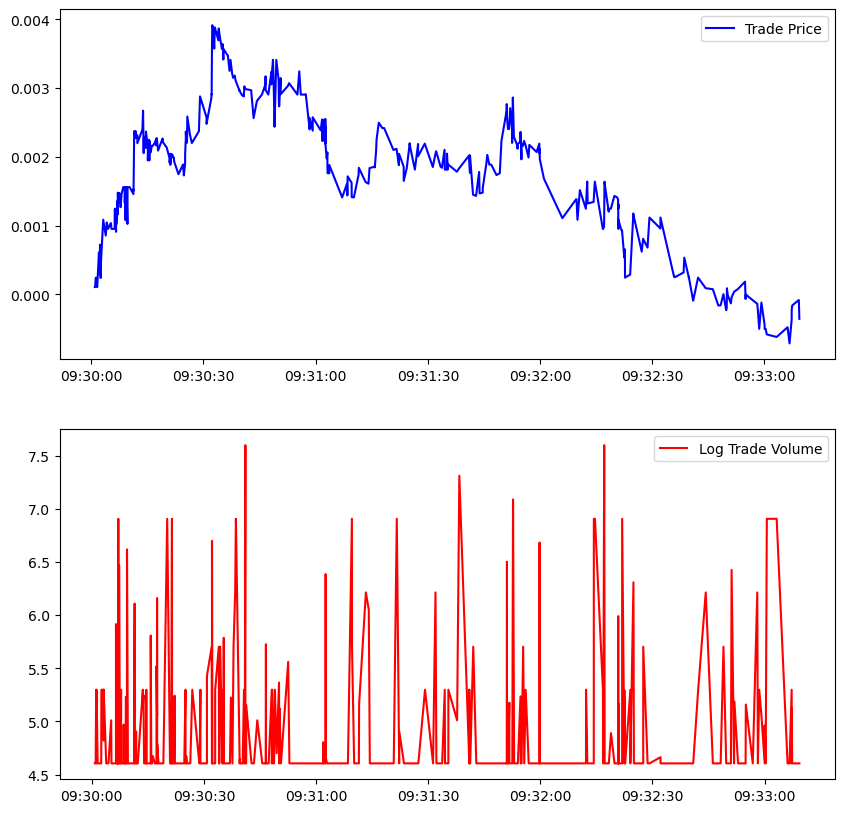

In [56]:
fig, ax = plt.subplots(2, 1, figsize=(10, 10))

log_trade_return = np.cumsum(regular_trades["Log_Return"].dropna())
trade_volume=regular_trades["Trade_Volume"]


ax[0].plot(log_trade_return, label="Trade Price",color='blue')

ax[1].plot(np.log(trade_volume), label="Log Trade Volume",color='red')

ax[0].legend()
ax[1].legend()

plt.show()



### Quick Performance of Trend Filtering

In [57]:
import sys
sys.path.append("../../")
from estimators.trend_filtering.trend_filter import Trend_Filter

from estimators.cv_base_estimator import cv_base_estimator

In [58]:
x=np.arange(1,len(regular_trades))


tf= Trend_Filter(x=x, y=log_trade_return.values, k=1, method="primal_dual")

start = time.time()
cv_base_estimator(tf)

print("Time taken: ", time.time() - start)

Performing  0 out of 3 iterations of cross validation
Performing cross validation for lambda = 0.001368700959068202
Performing cross validation for lambda = 0.0026425478331933033
Performing cross validation for lambda = 0.0051019611000116625
Performing cross validation for lambda = 0.009850344708643214
Performing cross validation for lambda = 0.019018038157694588
Performing cross validation for lambda = 0.03671808307887592
Performing cross validation for lambda = 0.07089151960933229
Performing cross validation for lambda = 0.1368700959068202
Performing cross validation for lambda = 0.26425478331933033
Performing cross validation for lambda = 0.5101961100011663
Performing cross validation for lambda = 0.9850344708643204
Performing cross validation for lambda = 1.9018038157694588
Performing cross validation for lambda = 3.6718083078875923
Performing cross validation for lambda = 7.089151960933222
Performing cross validation for lambda = 13.68700959068202
Performing  1 out of 3 iterations

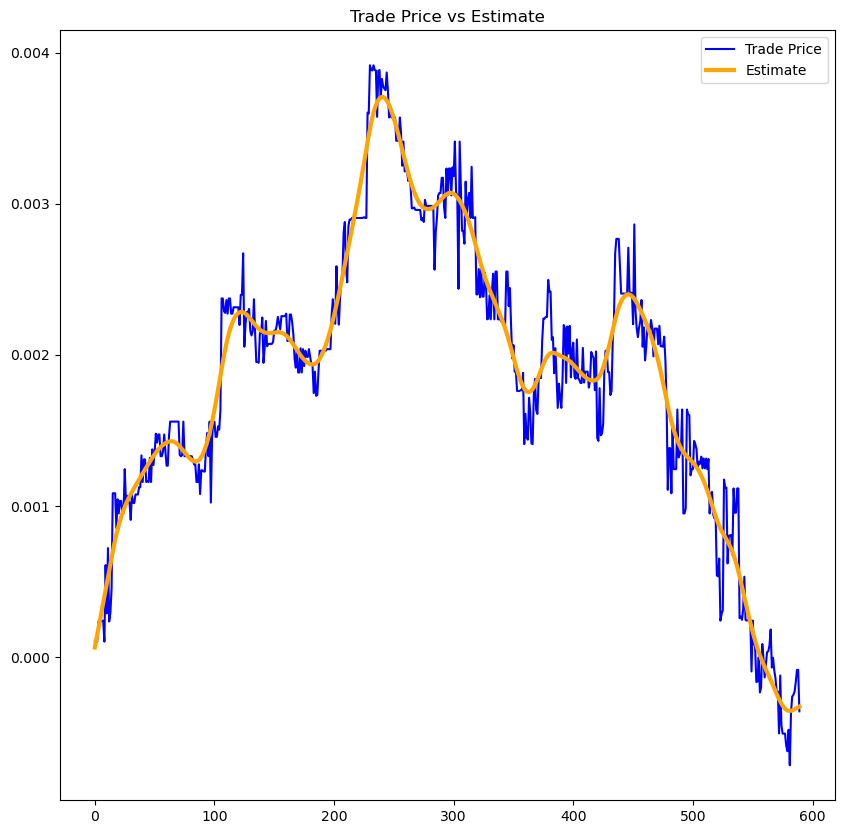

In [59]:


fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.plot(log_trade_return.values, label="Trade Price",color='blue')

ax.plot(tf.y_hat, label="Estimate",lw=3,color='orange')

ax.legend()

ax.set_title("Trade Price vs Estimate")

plt.show()

### Regime Detection from Estimated Trend

In [60]:
from estimators.regression.piecewise_polynomial import Piecewise_Polynomial_Model

In [61]:
regime_model=Piecewise_Polynomial_Model(x=x, y=tf.y_hat, k=1, method="continous_tf")

[230 235 240 361 437]
{1: [230], 2: [230, 437], 3: [230, 361, 437], 4: [230, 235, 361, 437], 5: [230, 235, 240, 361, 437], 0: []}
k: 0 mse: 8.322456303284045e-07
k: 1 mse: 2.2311475392739443e-07
k: 2 mse: 1.3907581785957466e-07
k: 3 mse: 1.1516511401698467e-07
k: 4 mse: 1.1447353224606682e-07
k: 5 mse: 1.1532684059078849e-07


In [62]:
regime_model.all_models

{0: 0.2680876243704076,
 1: 0.6233376117512714,
 2: 0.8280743251372952,
 3: 0.9939948674837776,
 4: 1.0074541977344373}

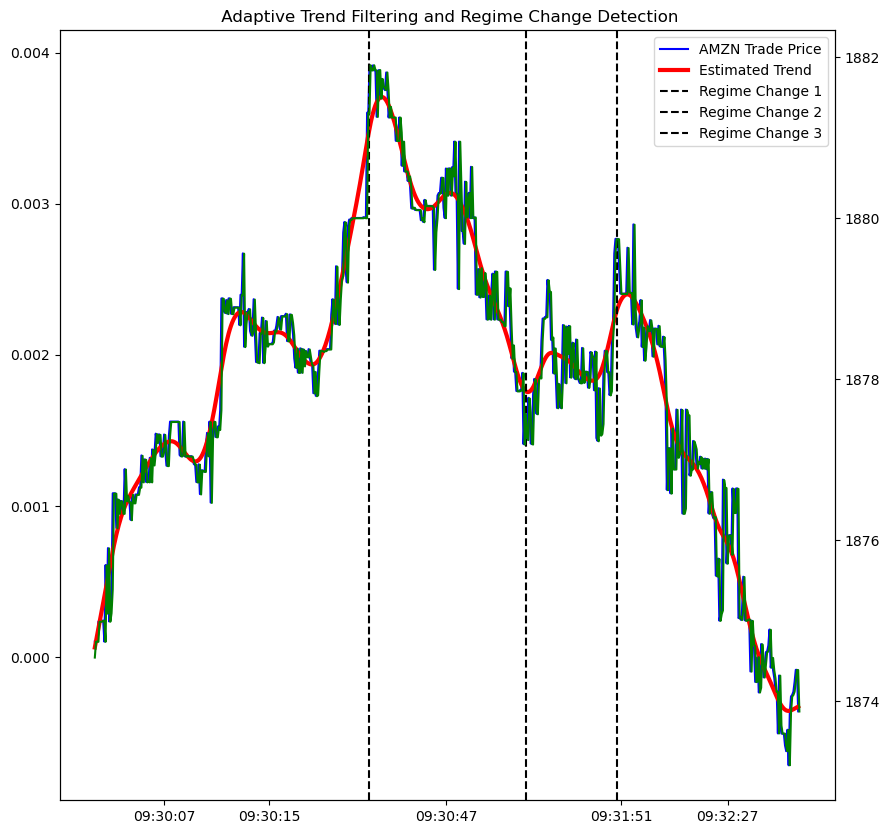

In [63]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.plot(log_trade_return.values, label="AMZN Trade Price",color='blue')
ax.plot(tf.y_hat, label="Estimated Trend ",color='red',lw=3)

for i in range(len(regime_model.knots)):
    ax.axvline(regime_model.knots[i],color='black',linestyle='--',label=f"Regime Change {i+1}")

ax.legend()
ax.set_title(" Adaptive Trend Filtering and Regime Change Detection")

quantiles=[0.1,0.25,0.5,0.75,0.9]
indices=[int(len(log_trade_return.values)*q)-1 for q in quantiles]
ax.set_xticks(indices,regular_trades.index[indices].strftime("%H:%M:%S"))

ax2=ax.twinx()
trade_price=regular_trades["Trade_Price"].values
ax2.plot(trade_price, label="Trade Price",color='green')

### Ratio of Loss Functions (Used for Model Selection)

In [37]:
model_selection=regime_model.all_models

model_selection

{0: 0.2680876243704076,
 1: 0.6233376117512714,
 2: 0.8280743251372952,
 3: 0.9939948674837776,
 4: 1.0074541977344373}

Text(0.5, 1.0, 'Model Selection')

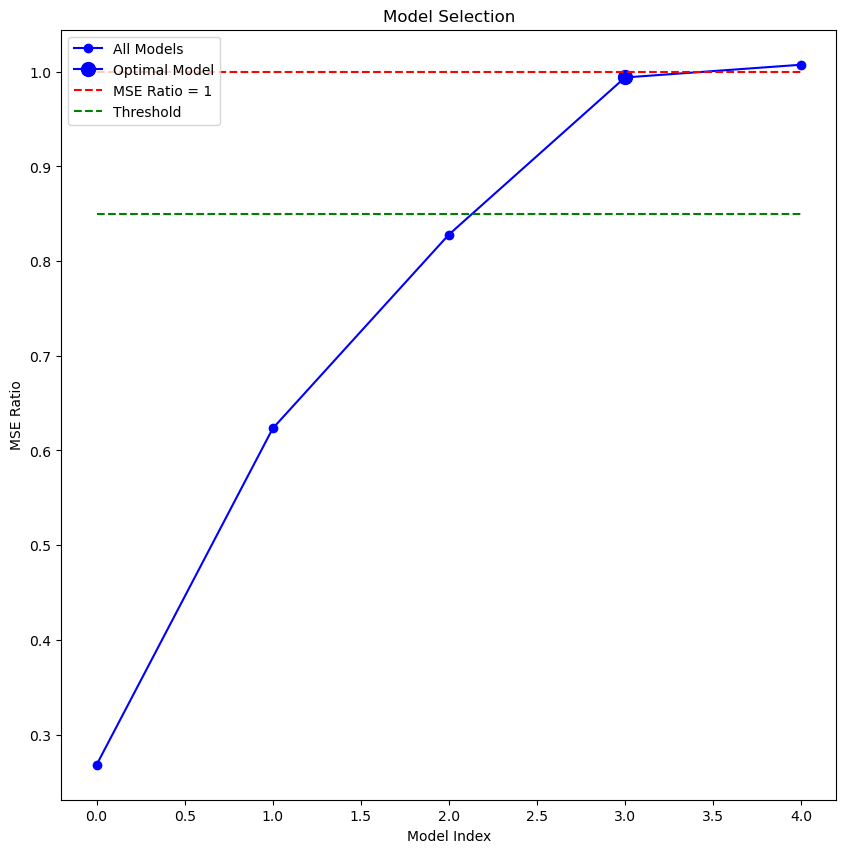

In [38]:
keys=list(model_selection.keys())
values=list(model_selection.values())
all_other_models=[(i,values[i]) for i in range(len(values)) if i !=regime_model.optimal_model]


nu=regime_model.nu

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.plot(keys,values,label="All Models",color='blue',marker='o')
ax.plot(regime_model.optimal_model,model_selection[regime_model.optimal_model],label="Optimal Model",color='blue',marker='o',markersize=10)
ax.hlines(1,keys[0],keys[-1],color='red',linestyle='--',label="MSE Ratio = 1")
ax.hlines(1-nu,keys[0],keys[-1],color='green',linestyle='--',label="Threshold")

ax.legend()
ax.set_ylabel("MSE Ratio")
ax.set_xlabel("Model Index")
ax.set_title("Model Selection")



### Time Dependent Trend Filtering

Careful consideration to round timestamps for observations with near identical timestamps

In [40]:
regular_trades['Round_Timestamp'] = regular_trades.index.round('1ms')

round_regular_trades = regular_trades.groupby('Round_Timestamp').agg({'Trade_Price': 'mean', 'Trade_Volume': 'sum', 'Log_Return': 'sum'})

round_regular_trades.head()

/tmp/ipykernel_112566/3849918056.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  regular_trades['Round_Timestamp'] = regular_trades.index.round('1ms')


,Trade_Price,Trade_Volume,Log_Return
Round_Timestamp,,,
2020-01-02 09:30:00.820,1874.5450,100.0,0.000000
2020-01-02 09:30:00.948,1874.7425,200.0,0.000105
2020-01-02 09:30:01.040,1874.7400,100.0,-0.000001
2020-01-02 09:30:01.160,1874.9900,200.0,0.000133
2020-01-02 09:30:01.180,1874.9900,200.0,0.000000


In [41]:
time_trade_price=np.cumsum(round_regular_trades["Log_Return"].values)

timestamps=round_regular_trades.index-regular_trades.index[0]

timestamps=timestamps.total_seconds().values




In [43]:
time_tf= Trend_Filter(x=timestamps, y=time_trade_price, k=1, method="primal_dual")

start = time.time()
cv_base_estimator(time_tf)

print("Time taken: ", time.time() - start)

Performing  0 out of 3 iterations of cross validation
Performing cross validation for lambda = 0.00022333439721465857
Performing cross validation for lambda = 0.0004311912134838508
Performing cross validation for lambda = 0.0008324998965876832
Performing cross validation for lambda = 0.0016073056596373819
Performing cross validation for lambda = 0.0031032213866830863
Performing cross validation for lambda = 0.005991382483490963
Performing cross validation for lambda = 0.0115675485537469
Performing cross validation for lambda = 0.022333439721465856
Performing cross validation for lambda = 0.04311912134838508
Performing cross validation for lambda = 0.08324998965876833
Performing cross validation for lambda = 0.160730565963738
Performing cross validation for lambda = 0.31032213866830866
Performing cross validation for lambda = 0.5991382483490963
Performing cross validation for lambda = 1.1567548553746887
Performing cross validation for lambda = 2.2333439721465855
Performing  1 out of 3 i

In [44]:
time_regime_model=Piecewise_Polynomial_Model(x=timestamps, y=time_tf.y_hat, k=1, method="continous_tf")

[137 165 172]
{1: [165], 2: [165, 172], 3: [137, 165, 172], 0: []}
k: 0 mse: 7.893951436379524e-07
k: 1 mse: 1.7042090504834553e-07
k: 2 mse: 1.7286466973147044e-07
k: 3 mse: 1.7985448301583308e-07


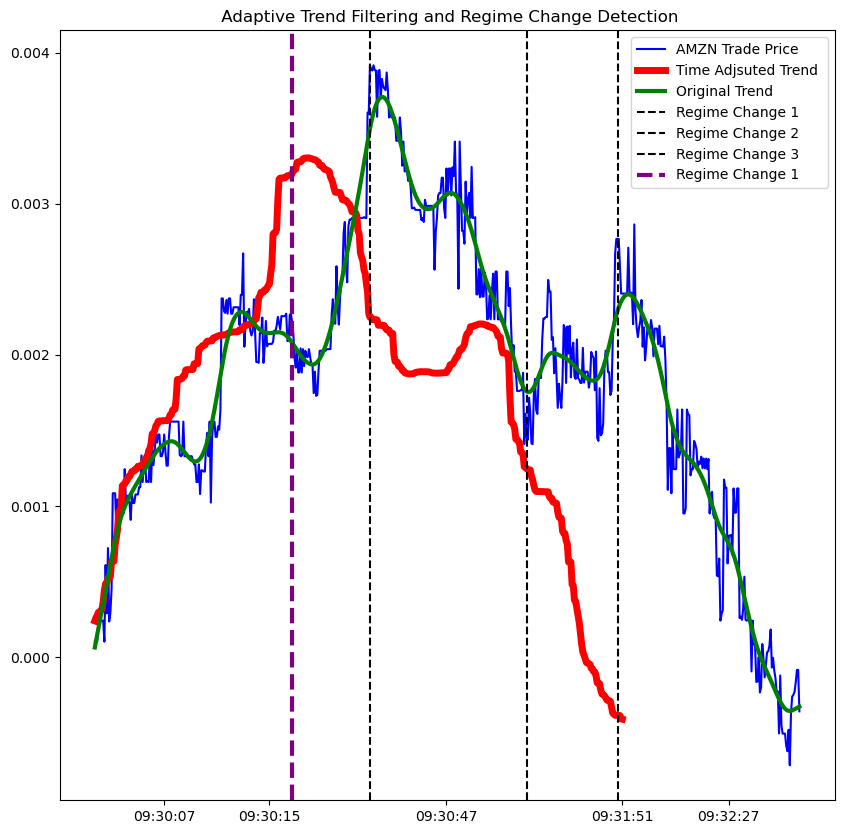

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.plot(log_trade_return.values, label="AMZN Trade Price",color='blue')
ax.plot(time_tf.y_hat, label="Time Adjsuted Trend ",color='red',lw=5)
ax.plot(tf.y_hat, label="Original Trend",color='green',lw=3)

for i in range(len(regime_model.knots)):
    ax.axvline(regime_model.knots[i],color='black',linestyle='--',label=f"Regime Change {i+1}")

for i in range(len(time_regime_model.knots)):
    ax.axvline(time_regime_model.knots[i],color='purple',linestyle='--',label=f"Regime Change {i+1}",lw=3)


ax.legend()
ax.set_title(" Adaptive Trend Filtering and Regime Change Detection")

quantiles=[0.1,0.25,0.5,0.75,0.9]
indices=[int(len(log_trade_return.values)*q)-1 for q in quantiles]
ax.set_xticks(indices,regular_trades.index[indices].strftime("%H:%M:%S"))

Text(0.5, 1.0, 'Model Selection')

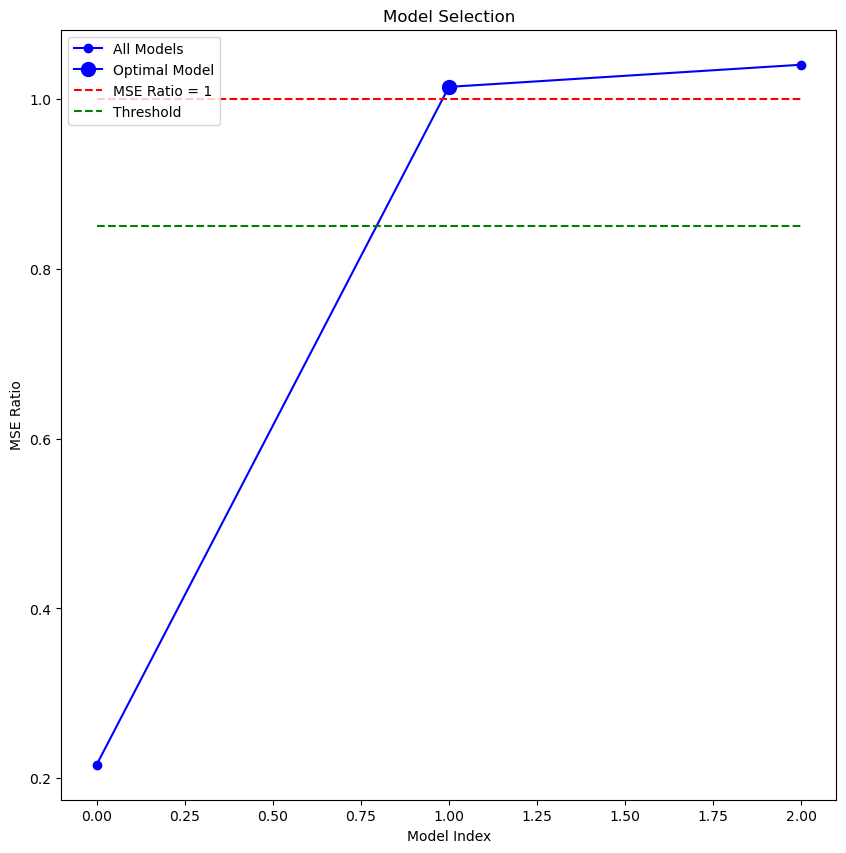

In [47]:
model_selection=time_regime_model.all_models

keys=list(model_selection.keys())
values=list(model_selection.values())
all_other_models=[(i,values[i]) for i in range(len(values)) if i != time_regime_model.optimal_model]

nu=time_regime_model.nu

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.plot(keys,values,label="All Models",color='blue',marker='o')
ax.plot(time_regime_model.optimal_model,model_selection[time_regime_model.optimal_model],label="Optimal Model",color='blue',marker='o',markersize=10)
ax.hlines(1,keys[0],keys[-1],color='red',linestyle='--',label="MSE Ratio = 1")
ax.hlines(1-nu,keys[0],keys[-1],color='green',linestyle='--',label="Threshold")

ax.legend()
ax.set_ylabel("MSE Ratio")
ax.set_xlabel("Model Index")
ax.set_title("Model Selection")
